# <font color="#FF6600">(expand for tip)</font> <font color="#445555">A note about opening notebooks in shared workspaces</font><a class="tocSkip">

 <font color="#445555">Please do not run or edit master copies of notebooks unless you intend to improve the code. As a general rule, it is good to be cautious when editing a notebook in a shared workspace, because you don't want to overwrite the work of your collaborators. Best practices is to test in a cloned workspace or duplicate notebook with an easily identifiable name.</font>  

# <font color="#FF6600">(expand for tip) </font> <font color="#445555">What is BigQuery? <a class="tocSkip"></font>

<font color="#445555">BigQuery is the Google Cloud Storage solution for structured data (like a spreadsheet optimized for quick retrieval of particular sections that you access with a "query"). To learn more, see this five-minute video from Google [here](https://www.youtube.com/watch?v=eyBK9nj-7AA). Many datasets, including the public-access 1,000 Genomes Project, are stored in BigQuery, for anyone to access.

# Notebook overview

In some cases, you may want to access BigQuery data that doesn't have a Data Explorer. This notebook demonstrates two additional ways to access BigQuery data in an R-based notebook:
1. Using SQL syntax
2. Using only R code to extract the data of interest from BigQuery

# R-environment setup

First, be sure to run the general notebook **`1_R environment setup`** in this workspace.   

Then run the cells below to add additional needed libraries, set the project id, and authorize the BigQuery client. Details about what each individual code cell does are included in green comments for reference. 

<font color="#445555">**Note about pink warnings**    
When you run these cells, output in a pink box does not signify that the code is broken, and will not affect how the notebook runs.</font>

In [1]:
# Load additional R libraries needed for this notebook into memory
# There may be warnings in pink indicating that objects are 'masked'.  These warnings can be ignored. 

# The bigrquery package makes it easy to work with data stored in Google BigQuery by allowing you to query 
# BigQuery tables and retrieve metadata about your projects, datasets, tables, and jobs
library(bigrquery)

# ggplot2 is a library of integrated plotting functions
library(ggplot2)

# dplyr is an R package for working with structured data (like BigQuery) both in and outside of R
library(dplyr)

# skimr handles different data types and returns a skim_df object which can be included in a 
# tidyverse pipeline or displayed nicely for the human reader
library(skimr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Set the project ID of the clould project to bill for queries to BigQuery
# Note that although you do pay a fee for the query in this notebook, it is very small (cents)
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')

In [3]:
# To access BigQuery, you must first autheniticate, or verify, your identity:
bq_auth(path=WORKSPACE)

# Retrieve filtered data

Now that we've set up the virtual compute environment, BigQuery authentication and billing, let’s retrieve a subset of fields and samples metadata in the [1000 Genomes](http://www.internationalgenome.org/data "1000 Genomes") dataset.

We will do this in two different ways. Both return the same results.

1. Using bigrquery (standard SQL)
2. Using dplyr and dbplyr

## Option 1: Using bigrquery (SQL)

To learn more about SQL syntax see the [BigQuery standard SQL reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/).

In [4]:
# Run a query from the public-access 1,000 genomes data in BigQuery with standard SQL 
# This query selects a subset of ten parameters from the dataset (`Sample`, `Gender`, etc.)
phase1_samples_tbl <- bigrquery::bq_project_query(
    BILLING_PROJECT_ID,
    query = '
SELECT
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
FROM
  `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
WHERE
  -- Only include information for samples in phase 1.
  In_Phase1_Integrated_Variant_Set = TRUE
  -- Only include information for samples with these relationships.
  AND Relationship IN ("", "unrel", "child", "father", "mother",
  "mat grandmother", "pat grandmother",
  "mat grandfather", "pat grandfather")
')

phase1_samples <- bigrquery::bq_table_download(phase1_samples_tbl)

In [5]:
# Print out the dimensions of the table (should be 1086 rows and 10 columns were retrieved into the "phase1_samples") table
dim(phase1_samples)

[1] 1086   10

In [6]:
# Output summary statistics of the samples (sanity check)
print(skim(phase1_samples))

── Data Summary ────────────────────────
                           Values        
Name                       phase1_samples
Number of rows             1086          
Number of columns          10            
_______________________                  
Column type frequency:                   
  character                9             
  numeric                  1             
________________________                 
Group variables            None          

── Variable type: character ────────────────────────────────────────────────────
  skim_variable                n_missing complete_rate   min   max empty
1 Sample                               0             1     7     7     0
2 Gender                               0             1     4     6     0
3 Relationship                         0             1     0    15   559
4 Population                           0             1     3     3     0
5 Population_Description               0             1    16    58     0
6 Super_Population 

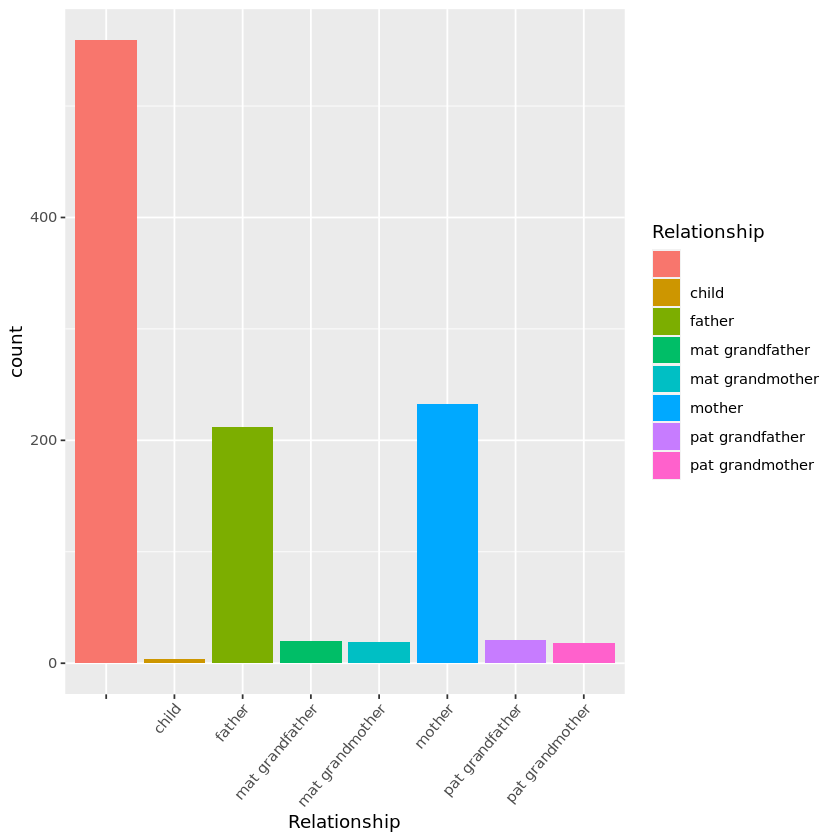

In [7]:
# Plot the relationship of individuals contained in the data set
# The null condition (first column) indicates that no individuals were related to this person
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

## Option 2: Using dplyr

**dplyr** is an R package that provides a common set of "verbs" to manipulate tabular data.

To learn more about dplyr see [R for Data Science Chapter 5 Data transformation](http://r4ds.had.co.nz/transform.html "Chapter 5").

In [8]:
# Create a "connection" to a public BigQuery dataset
dbcon <- bigrquery::src_bigquery(project = 'bigquery-public-data',
                                 dataset = 'human_genome_variants',
                                 billing = BILLING_PROJECT_ID)

# Create a 'virtual dataframe' backed by a BigQuery table
sample_info <- dplyr::tbl(dbcon, '1000_genomes_sample_info')

In [9]:
# Filter to only include information for samples in phase 1 with the relationshionships below
phase1_only <- sample_info %>% filter(
    In_Phase1_Integrated_Variant_Set == TRUE,
    Relationship %in% c(
      '', 'unrel', 'child', 'father', 'mother',
      'mat grandmother', 'pat grandmother',
      'mat grandfather', 'pat grandfather')
  )

# Nothing is computed on BigQuery yet.

In [10]:
# Define a variable, "sample_fields", with the included parameters
sample_fields <- phase1_only %>% select(
  Sample,
  Gender,
  Relationship,
  Population,
  Population_Description,
  Super_Population,
  Super_Population_Description,
  Total_Exome_Sequence,
  Main_Project_E_Platform,
  Main_Project_E_Centers
  )

# Still nothing computed on BigQuery.

In [11]:
# Optional sanity check: Take a look at the SQL
dplyr::show_query(sample_fields)

<SQL>
SELECT `Sample`, `Gender`, `Relationship`, `Population`, `Population_Description`, `Super_Population`, `Super_Population_Description`, `Total_Exome_Sequence`, `Main_Project_E_Platform`, `Main_Project_E_Centers`
FROM `1000_genomes_sample_info`
WHERE ((`In_Phase1_Integrated_Variant_Set` = TRUE) AND (`Relationship` IN ('', 'unrel', 'child', 'father', 'mother', 'mat grandmother', 'pat grandmother', 'mat grandfather', 'pat grandfather')))


In [12]:
# Optional: See how much data this will return
sample_fields %>% summarize(cnt = n()) %>% collect()

cnt 
1 1086

In [13]:
# Execute the query and return all results into an in-memory table in R
phase1_samples <- sample_fields %>% collect()

In [14]:
# Sanity check: What are the dimensions of the phase1_sample table?
dim(phase1_samples)

[1] 1086   10

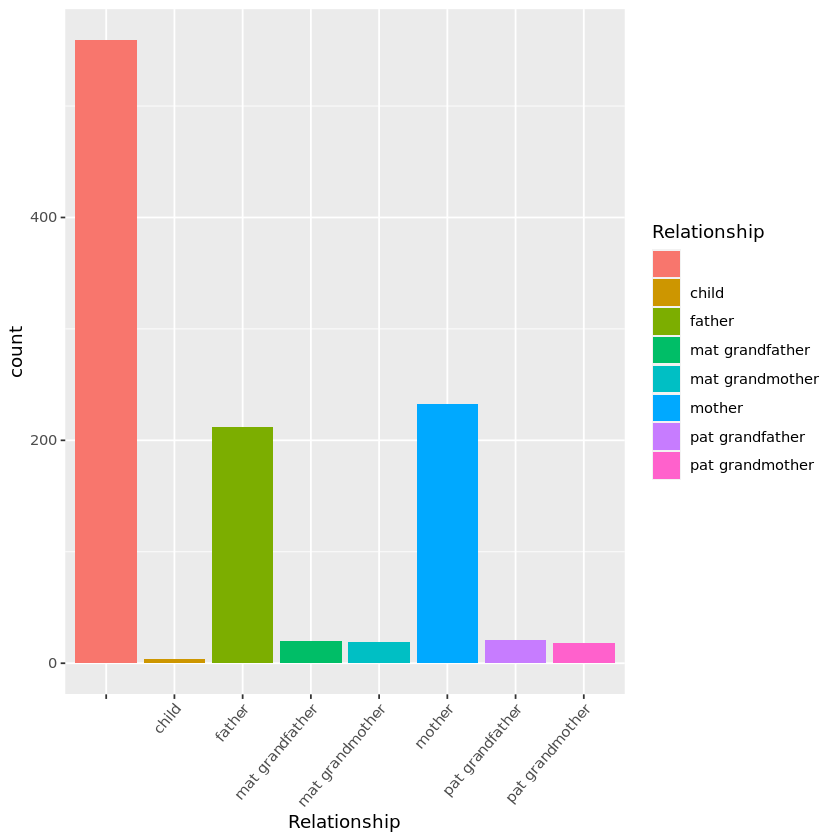

In [15]:
# Plot results
ggplot(data = phase1_samples,
       aes(x=Relationship, fill=Relationship)) +
  geom_bar() +
  theme(axis.text.x = element_text(angle = 50, hjust = 1, vjust = 1))

# Provenance

In [16]:
# Including this information allows you to easly go back and see the details of your notebook environment
# Provenance is also recommended as Best Practices for reproducible research
devtools::session_info()

─ Session info ───────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.1.1 (2021-08-10)
 os       Ubuntu 18.04.5 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2021-10-12                  

─ Packages ───────────────────────────────────────────────────────────────────
 package     * version date       lib source        
 assertthat    0.2.1   2019-03-21 [2] CRAN (R 4.1.1)
 base64enc     0.1-3   2015-07-28 [2] CRAN (R 4.1.1)
 bigrquery   * 1.4.0   2021-08-05 [2] CRAN (R 4.1.1)
 bit           4.0.4   2020-08-04 [2] CRAN (R 4.1.1)
 bit64         4.0.5   2020-08-30 [2] CRAN (R 4.1.1)
 blob          1.2.2   2021-07-23 [2] CRAN (R 4.1.1)
 cachem        1.0.6   2021-08-19 [2] CRAN (R 4.1.1)
 callr         3.7.0   2021

Copyright 2019 The Broad Institute, Inc., Verily Life Sciences, LLC All rights reserved.

This software may be modified and distributed under the terms of the BSD license. See the LICENSE file for details.